In [93]:
import torch, yaml, matplotlib.pyplot as plt, torch.nn.functional as F
from src.TorchDSP.utils import circsum, VmapConv1d, Dconv, conv_circ
from src.TorchDSP.dsp import LDBP, get_beta1, get_beta2, dispersion_kernel, get_omega, TorchTime

with open('configs/metadsp/fdbp.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

dbp = LDBP(cfg['model_info']['DBP_info'])

conv = lambda x,h: conv_circ(x,h)
sft = torch.fft.fftshift   
isft = torch.fft.ifftshift
freq = torch.fft.fftfreq

# kernel = dispersion_kernel(2000e3, 5001, 160e9)[0]
# plt.plot(torch.abs(kernel))

In [145]:
from typing import Union

def get_omega(Fs:torch.Tensor, Nfft:int) -> torch.Tensor:
    ''' 
    Get signal fft angular frequency.
    Input:
        Fs: sampling frequency. [Hz]          [batch,]
        Nfft: number of sampling points.      
    Output:
        omega: torch.Tensor [batch, Nfft]
    '''
    return 2*torch.pi*Fs[:,None] * torch.fft.fftfreq(Nfft)[None,:].to(Fs.device)  # [batch, Nfft]

        
def dispersion_kernel(dz:float, dtaps:int, Fs, beta2:float=-2.1044895291667417e-26, beta1: Union[torch.Tensor, float, int]=torch.zeros(1), domain='time') -> torch.Tensor:
    ''' 
    Dispersion kernel in time domain or frequency domain.
    Input:
        dz: Dispersion distance.              [m]
        dtaps: length of kernel.     
        Fs: Sampling rate of signal.          [Hz]         [batch] or float
        beta2: 2 order  dispersion coeff.     [s^2/m]
        beta1: 1 order dispersion coeff.      [s/m]        [batch] or float
        domain: 'time' or 'freq'
    Output:
        h:jnp.array. (dtaps,)
        h is symmetric: jnp.flip(h) = h.
    '''
    if type(Fs) == float or type(Fs) == int:
        Fs = torch.tensor([Fs])
    if type(beta1) == float or type(beta1) == int:
        beta1 = torch.tensor([beta1])

    omega = get_omega(Fs, dtaps)      # (batch, dtaps)
    kernel = torch.exp(-1j*beta1[:,None]*omega*dz - 1j*(beta2/2)*(omega**2)*dz)  # beta1: (batch,)

    if domain == 'time':
        return torch.fft.fftshift(torch.fft.ifft(kernel, axis=-1), axis=-1)
    elif domain == 'freq':
        return kernel
    else:
        raise(ValueError)
    

def D(z, dtaps=101, Fs=160e9):
    '''
    1d -> 1d
    '''
    k = dispersion_kernel(z, dtaps, Fs)   # [batch, N]

    def Disp(x):
        return Dconv(x[None,:,None], k, stride=1)[0,:,0]

    return Disp

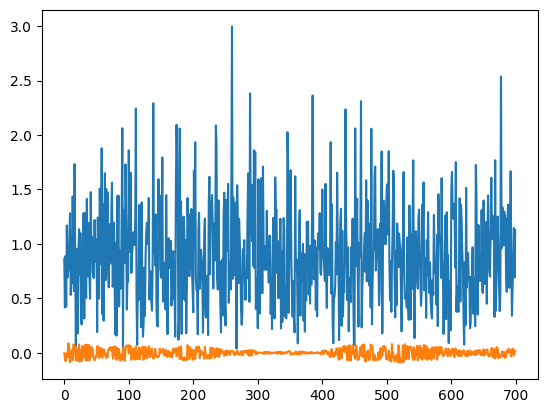

In [148]:
x = torch.randn(1000, dtype=torch.complex64)

L = 10e3
plt.plot(torch.abs(D(3*L, 301)(x)))
plt.plot(torch.abs(D(3*L, 301)(x)) - torch.abs(D(L)(D(L)(D(L)(x)))))

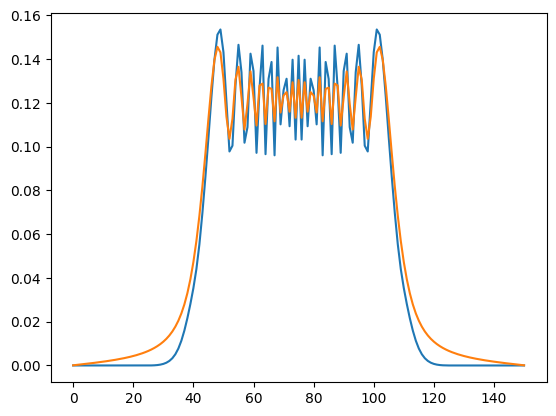

In [160]:
k = dispersion_kernel(20e3, 151, 160e9)[0]
kernel = isft(torch.cat([torch.zeros(50), dispersion_kernel(10e3, 51, 160e9)[0], torch.zeros(50)]))
kernel2 = sft(conv_circ(kernel, kernel))

plt.plot(torch.abs(kernel2))
plt.plot(torch.abs(k))

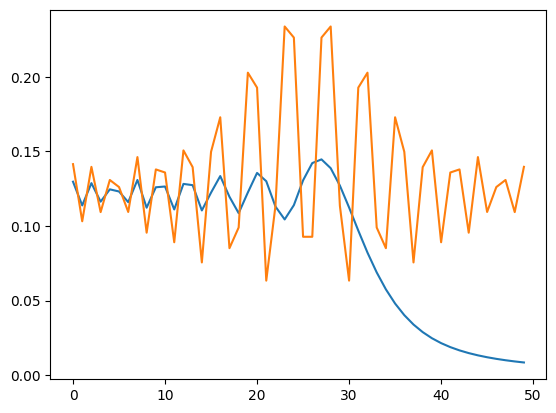

In [175]:
k1 = isft(dispersion_kernel(20e3, 1001, 160e9)[0])[0:50]
k2 = isft(dispersion_kernel(20e3, 51, 160e9)[0])[0:50]


plt.plot(torch.abs(k1))
plt.plot(torch.abs(k2))

In [177]:
import h5py 

with h5py.File('dataset_A800/train.h5') as f:
    f.visit(print)

Nmodes2_Rs160_Nch21_Pch-1_700062844
Nmodes2_Rs160_Nch21_Pch-1_700062844/SignalRx
Nmodes2_Rs160_Nch21_Pch-1_700062844/SymbTx
Nmodes2_Rs160_Nch21_Pch-1_700062844/pulse
Nmodes2_Rs160_Nch21_Pch-2_700062844
Nmodes2_Rs160_Nch21_Pch-2_700062844/SignalRx
Nmodes2_Rs160_Nch21_Pch-2_700062844/SymbTx
Nmodes2_Rs160_Nch21_Pch-2_700062844/pulse
Nmodes2_Rs160_Nch21_Pch-3_700062844
Nmodes2_Rs160_Nch21_Pch-3_700062844/SignalRx
Nmodes2_Rs160_Nch21_Pch-3_700062844/SymbTx
Nmodes2_Rs160_Nch21_Pch-3_700062844/pulse
Nmodes2_Rs160_Nch21_Pch0_700062844
Nmodes2_Rs160_Nch21_Pch0_700062844/SignalRx
Nmodes2_Rs160_Nch21_Pch0_700062844/SymbTx
Nmodes2_Rs160_Nch21_Pch0_700062844/pulse
Nmodes2_Rs160_Nch21_Pch1_700062844
Nmodes2_Rs160_Nch21_Pch1_700062844/SignalRx
Nmodes2_Rs160_Nch21_Pch1_700062844/SymbTx
Nmodes2_Rs160_Nch21_Pch1_700062844/pulse
Nmodes2_Rs160_Nch21_Pch2_700062844
Nmodes2_Rs160_Nch21_Pch2_700062844/SignalRx
Nmodes2_Rs160_Nch21_Pch2_700062844/SymbTx
Nmodes2_Rs160_Nch21_Pch2_700062844/pulse
Nmodes2_Rs160_Nc